<a href="https://colab.research.google.com/github/NoahIslam/DeepLearningSpectrogramModels/blob/main/CNN_LSTM_SpectrogramDeliriumClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FOLDERNAME = 'EDF Files'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


# Preprocessing

In [ ]:
!pip install pyedflib
from datetime import datetime
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import pickle
import pyedflib
import random

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print_every = 5
print('using device:', device)

plt.ioff()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 70.8 MB/s eta 0:00:00
using device: cuda


In [ ]:
def get_list_of_files(filepath):
  entries = os.listdir(filepath)
  files = []
  for item in entries:
    if os.path.isdir(os.path.join(filepath, item)):
      files.extend(get_list_of_files(os.path.join(filepath, item)))
  files.extend([os.path.join(filepath, x) for x in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, item))])
  return files

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/EEG_Clinical_Data_Master_File_Broadcasted.xlsx')
df.to_csv('EEG_Data.csv', index=False)

In [ ]:
def to_datetime(timedate):
  rem_paren = timedate.split('/')[-1]
  filename = rem_paren.split("_")
  EEG_ID = filename[0]
  date = filename[1]
  if date[len(date)-4:len(date)] == '2019' or date[len(date)-4:len(date)] == '2020' or date[len(date)-4:len(date)] == '2018' or date[len(date)-4:len(date)] == '2017' or date[len(date)-4:len(date)] == '2016':
    month = date[len(date)-8:len(date)-6]
    day = date[len(date)-6:len(date)-4]
    year = date[len(date)-4:len(date)]
  else:
    year = date[len(date)-8:len(date)-4]
    month = date[len(date)-4:len(date)-2]
    day = date[len(date)-2:len(date)]
  try:
    return (int(EEG_ID), datetime(int(year), int(month), int(day), 0, 0))
  except Exception as e:
    return ()

def csv_to_dict():
  folder_path = '/content/drive/MyDrive/EDF Files/'
  filename_to_score = {}
  filename_to_spec = {}
  files = get_list_of_files(folder_path)
  shitlist = []
  not_edf = ['/content/drive/MyDrive/EDF Files/August 2019 Lettered/2090_CK20190809_1228_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2087_JC20190807_1015_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2101_RC20190828_1140_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Numbered/2071_MM20190723_1013_3.edf', '/content/drive/MyDrive/EDF Files/July 2019 Numbered/2077_JJ20190729_1253_3.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/July 2017 EDF files/week of 17Jul10 - 17Jul26/0551_KR20170711_1016-1026.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Jun 2017 EDF files/week of 6.7.17 - 6.12.17/0504_DT20170607_1130-1140.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/May 2017 EDF files/0475_20170523_1623-1633.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1185_TS20180419_1315-1320.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1189_LH20180419_1330-1335.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1179_MH20180419_1410-1415.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1177_SM20180419_1350-1355.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1195_JK20180420_1430-1435.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1184_GR20180420_1435-1440.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1185_TS20180420_1530-1535.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1179_MH20180420_1450-1455.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Sep 2017 EDF files/week of 17Sep7 - 17Sep14/0714_RC20170914_0924-0931.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Sep 2017 EDF files/week of 17Sep7 - 17Sep14/0716_DA20170914_1035-1040.DAT', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Sep 2017 EDF files/week of 17Sep7 - 17Sep14/0710_BK20170914_1123-1128.DAT']
  # for length of 140
  too_short = ['/content/drive/MyDrive/EDF Files/November 2018/1561_RW20181130_0955-0956.edf', '/content/drive/MyDrive/EDF Files/November 2018/1562_SG20181130_1019-1020.edf', '/content/drive/MyDrive/EDF Files/November 2018/1561_RW20181130_1416.edf', '/content/drive/MyDrive/EDF Files/November 2018/1562_SG20181130_1440.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2351_FS01272020_1118_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Numbered/2200_BF20191004_1020_2.edf', '/content/drive/MyDrive/EDF Files/October 2019 Numbered/2227_TM20191021_1046_2.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1989_WH20190516_1147-1150_B.edf', '/content/drive/MyDrive/EDF Files/December 2018/1561_RW20181203_stabilizing.edf', '/content/drive/MyDrive/EDF Files/December 2018/1568_LW20181203_stabilizing.edf', '/content/drive/MyDrive/EDF Files/August 2019 Numbered/2093_BL08142019_1419_3.edf', '/content/drive/MyDrive/EDF Files/September 2019 Numbered/2165_LP20190920_1027_3.edf', '/content/drive/MyDrive/EDF Files/January 2019/1592_JE20190110_1053-1055.edf', '/content/drive/MyDrive/EDF Files/January 2019/1601_LS20190118_1003-1006.edf', '/content/drive/MyDrive/EDF Files/February 2019/1667_MM20190223_1031-1034.edf', '/content/drive/MyDrive/EDF Files/February 2019/1710_CG20190226_1609-1611.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1832_CP20190402_0849-0850.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1846_MS20190402_0923-0924.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1851_WM20190403_0858-0859.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1850_LH20190403_0949-0951.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1850_LH20190403_0949-0951(1).edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1852_DI20190403_1455-1456.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1865_BK20190404_0917-0918(1).edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1865_BK20190404_0917-0918.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1863_DH20190404_1001-1002.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1876_JE20190405_1455-1456.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1827_DS20190406_0941-0942.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1831_DE20190406_1104-1105.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1865_BK20190406_1121-1122.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1886_DD20190409_0835-0837.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1827_DS20190409_0903-0904.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1893_RW20190410_0909-0910.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1891_CT20190410_0947-0947.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1894_RD20190410_1448-1449.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1908_DC20190412_1417-1418.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1888_RK20190413_0914-0915.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1908_DC20190413_0929-0930.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1907_TC20190413_0954-0955.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1905_LS20190413_1024-1025.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1891_CT20190413_1037-1038.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1891_CT20190416_1004-1005.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1905_LS20190416_1019-1020.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1876_JE20190416_1039-1040.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1910_RK20190416_1056-1057.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1911_RR20190416_1440-1441.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1914_DB20190416_1601-1602.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1918_PK20190418_0958-0959_1.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1912_SC20190423_1519_1.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1876_JE20190423_1541_1.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1935_MB20190423_1556_1.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1960_RK20190425_1549_2.edf', '/content/drive/MyDrive/EDF Files/March 2019/1692_DP20190302_1030-1031.edf', '/content/drive/MyDrive/EDF Files/March 2019/1728_JS20190302_1044-1045.edf', '/content/drive/MyDrive/EDF Files/March 2019/1716_JR20190302_1058-1059.edf', '/content/drive/MyDrive/EDF Files/March 2019/1726_SB20190302_1132-1133.edf', '/content/drive/MyDrive/EDF Files/March 2019/1712_GK20190302_1149-1150.edf', '/content/drive/MyDrive/EDF Files/March 2019/1666_RC20190302_1214-1215.edf', '/content/drive/MyDrive/EDF Files/March 2019/1740_JR20190304_1331-1332.edf', '/content/drive/MyDrive/EDF Files/March 2019/1748_MS20190306_0921-0922.edf', '/content/drive/MyDrive/EDF Files/March 2019/1747_MT20190306_0955-0956.edf', '/content/drive/MyDrive/EDF Files/March 2019/1752_PM20190306_1431-1432.edf', '/content/drive/MyDrive/EDF Files/March 2019/1759_LB20190307_0858-0859.edf', '/content/drive/MyDrive/EDF Files/March 2019/1761_GK20190307_0939-0940.edf', '/content/drive/MyDrive/EDF Files/March 2019/1762_KT20190307_1421-1422.edf', '/content/drive/MyDrive/EDF Files/March 2019/1726_SB20190308_1157-1158.edf', '/content/drive/MyDrive/EDF Files/March 2019/1768_WW20190308_1345-1346.edf', '/content/drive/MyDrive/EDF Files/March 2019/1762_KT20190308_1358-1359.edf', '/content/drive/MyDrive/EDF Files/March 2019/1746_MM20190308_1422-1423.edf', '/content/drive/MyDrive/EDF Files/March 2019/1742_RF20190308_1441-1442.edf', '/content/drive/MyDrive/EDF Files/March 2019/1772_CZ20190312_0923-0924.edf', '/content/drive/MyDrive/EDF Files/March 2019/1766_WS20190312_0955-0956.edf', '/content/drive/MyDrive/EDF Files/March 2019/1766_WS20190312_0956-0958.edf', '/content/drive/MyDrive/EDF Files/March 2019/1742_RF20190312_1009-1010.edf', '/content/drive/MyDrive/EDF Files/March 2019/1761_GK20190312_1029-1030.edf', '/content/drive/MyDrive/EDF Files/March 2019/1752_PM20190312_1046-1047.edf', '/content/drive/MyDrive/EDF Files/March 2019/1776_KW20190312_1508-1509.edf', '/content/drive/MyDrive/EDF Files/March 2019/1780_MD20190313_0925-0926.edf', '/content/drive/MyDrive/EDF Files/March 2019/1742_RF20190313_0946-0947.edf', '/content/drive/MyDrive/EDF Files/March 2019/1766_WS20190313_1003-1004.edf', '/content/drive/MyDrive/EDF Files/March 2019/1776_KW20190313_1014-1015.edf', '/content/drive/MyDrive/EDF Files/March 2019/1782_SD20190313_1437-1439.edf', '/content/drive/MyDrive/EDF Files/March 2019/1786_SS20190313_1500-1501.edf', '/content/drive/MyDrive/EDF Files/March 2019/1789_KT20190314_0911-0912.edf', '/content/drive/MyDrive/EDF Files/March 2019/1790_KN20190314_1353-1353.edf', '/content/drive/MyDrive/EDF Files/March 2019/1752_PM20190315_1215-1216.edf', '/content/drive/MyDrive/EDF Files/March 2019/1784_CR20190315_1243-1244.edf', '/content/drive/MyDrive/EDF Files/March 2019/1761_GK20190315_1303-1304.edf', '/content/drive/MyDrive/EDF Files/March 2019/1793_DD20190315_1318-1319.edf', '/content/drive/MyDrive/EDF Files/March 2019/1787_PL20190315_1328-1329.edf', '/content/drive/MyDrive/EDF Files/March 2019/1786_SS20190315_1431-1432.edf', '/content/drive/MyDrive/EDF Files/March 2019/1782_SD20190315_1500-1501.edf', '/content/drive/MyDrive/EDF Files/March 2019/1797_DR20190325_1345-1346.edf', '/content/drive/MyDrive/EDF Files/March 2019/1798_KG20190325_1411-1412.edf', '/content/drive/MyDrive/EDF Files/March 2019/1798_KG20190326_1439-1440.edf', '/content/drive/MyDrive/EDF Files/March 2019/1794_VK20190326_1542-1543.edf', '/content/drive/MyDrive/EDF Files/March 2019/1819_GN20190327_0928-0929.edf', '/content/drive/MyDrive/EDF Files/March 2019/1817_CH20190327_1402-1403.edf', '/content/drive/MyDrive/EDF Files/March 2019/1807_JL20190328_0852-0853.edf', '/content/drive/MyDrive/EDF Files/March 2019/1827_DS20190328_0903-0904.edf', '/content/drive/MyDrive/EDF Files/March 2019/1827_DS20190328_0904-0907.edf', '/content/drive/MyDrive/EDF Files/March 2019/1830_LS20190328_1447-1447.edf', '/content/drive/MyDrive/EDF Files/March 2019/1830_LS20190329_1235-1236.edf', '/content/drive/MyDrive/EDF Files/March 2019/1827_DS20190329_1303-1304.edf', '/content/drive/MyDrive/EDF Files/March 2019/1835_DH20190329_1340-1341.edf', '/content/drive/MyDrive/EDF Files/March 2019/1807_JL20190329_1343-1344.edf', '/content/drive/MyDrive/EDF Files/March 2019/1832_CP20190402_0849-0850.edf', '/content/drive/MyDrive/EDF Files/March 2019/1827_DS20190402_0908-0909.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18June16-18June22/1331_SA20180619_1522-1524.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/November 2018/1559_BS20181119_1035-1040.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/November 2018/1560_GM20181127_1509-1512.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Sept 2016 EDF files/0255_20160915_1042-1054.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar16 - 18Mar23/1074_MK20180309_1535-1440.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar16 - 18Mar23/1099_DN20180319_1315-1320.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar16 - 18Mar23/1114_DM20180323_1335-1340.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18oct22 - 18oct31/1511_IF20181022_1012-1017.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18oct22 - 18oct31/1515_SE20181022_1449-1454.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18oct22 - 18oct31/1519_DB20181022_1340-1345.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18oct22 - 18oct31/1514_JS20181022_1426-1430.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 17Dec14 - 18Jan4/0915_JM20171228_1400-1403.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Jun 2017 EDF files/week of 6.7.17 - 6.12.17/0515_20170610_1236-1246.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18July15-18July20/1373_HS20180716_1042-1045.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Mar 2017 EDF files/0415_20170302_1707-1709.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar8 - 18Mar16/1074_MK20180309_1535-1440.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18July21-18July27/1400_LL20180724_1502-1504.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Aug27 - 18Aug31/1446_RT20180829_0858-0903.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr21 - 18Apr27/1208_LW20180426_1305-1310.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr21 - 18Apr27/1212_DW20180426_1250-1255.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr21 - 18Apr27/1184_GR20180426_1320-1325.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr21 - 18Apr27/1184_GR20180427_0958-1003.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr21 - 18Apr27/1206_20180427_1405-1410.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar23 - 18Mar30/1114_DM20180323_1335-1340.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar23 - 18Mar30/Theo2_old_20180328.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar31 - 18Apr6/1145_GP20180405_1005-1010.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar31 - 18Apr6/1145_GP20180406_1340-1345.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar31 - 18Apr6/1155_AD20180406_1405-1410.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Aug 2017 EDF files/week of 17Aug25 to 17Aug31/0679_TS20170826_1038-1045.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Aug 2017 EDF files/week of 17Aug4 to 17Aug10/0653_TF20170807_0938-0948.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 17Nov3 - 17Nov09/0823_CG20171102_1453-1457.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Subjects 1-26/0017_20160308_1138.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 17Oct13 - 17Oct19/0794_FN20171019_0936-0940.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr28 - 18May4/1231_AB20180503_1210-1215.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr28 - 18May4/1233_MG20180504_1435-1440.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1188_GV20180417_1000-1005.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1185_TS20180419_1315-1320.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1179_MH20180419_1410-1415.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1177_SM20180419_1350-1355.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1189_LH20180419_1330-1335.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1184_GR20180420_1435-1440.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Apr14 - 18Apr20/1185_TS20180420_1530-1535.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Sep 2017 EDF files/week of 15Sep17 to 17Sep21/0730_20170921_0947-0957.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar1 - 18Mar8/1052_DM20180303_1005-1010.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar1 - 18Mar8/1054_ML20180303_0945-0950.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar1 - 18Mar8/1063_KP20180308_1330-1335.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar1 - 18Mar8/1063_KP20180307_1400-1403.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Mar1 - 18Mar8/1067_JP20180308_1435-1440.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Aug5-18Aug11/1408_DG20180809_1532-1537.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/Feb - May 2016 EDF files/0017_20160308_1138.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Aug19 - 18Aug26/1433_RL20180819_0919-0924.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18June30-18July6/1346_TT20180704_1046-1048.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18June30-18July6/1346_TT20180705_1005-1006.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Jan18 - 18Feb15/0961_PW20180125_1401-1404.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Jan18 - 18Feb15/0991_RC20180208_1329-1333.edf', '/content/drive/MyDrive/EDF Files/EDF Files - Old EEG Device/week of 18Jan18 - 18Feb15/0991_RC20180209_1512-1515.edf']

  one_channel = ['/content/drive/MyDrive/EDF Files/January 2020 Numbered/2332_GV20200121_1419.edf', '/content/drive/MyDrive/EDF Files/January 2020 Numbered/2349_BR01262020_1130.edf', '/content/drive/MyDrive/EDF Files/January 2020 Numbered/2367_SR01312020_1520.edf', '/content/drive/MyDrive/EDF Files/February 2020 Lettered/2379_MP20200204_1320_A.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2327_DP20200103_1328_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2333_SK20200121_1609_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2338_AL20200122_1141_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2341_JE20200123_1210_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2343_CC01242020_1143_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2342_SV20200124_1145_A.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2344_JP20200124_1510_A.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2348_CR01252020_1145_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2355_HL01282020_1019_A.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2349_BR20200129_1113_A.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2361_GH20200129_1150_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2356_ST20200129_1235_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2349_BR20200131_1158_B.edf', '/content/drive/MyDrive/EDF Files/January 2020 Lettered/2357_MC20200128_1210_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2305_MH20191202_1059_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2306_DZ20191202_1316_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2307_RG20191203_0942_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2308_CM20191203_1402_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2306_DZ20191203_1304_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2311_GD20191204_0914_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2306_DZ20191204_1006_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2312_AK20191204_1117_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2314_PH20191204_1405_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2315_RK20191204_1442_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2306_DZ20191206_1154_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2309_RR20191205_1231_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2321_MM12052019_1411_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2321_MM12052019_1313_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2306_DZ20191206_0958_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2324_LJ20191206_0953_A.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2312_AK20191206_1033_B.edf', '/content/drive/MyDrive/EDF Files/December 2019 Lettered/2325_SB20191211_1302_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2174_PR20191001_0917_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2189_DH20191002_0910_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2195_VC20191003_0841_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2189_DH20191003_1319_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2195_VC20191004_1017_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2200_BF20191004_1020_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2203_ER20191006_1011_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2203_ER20191007_1030_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2203_ER20191008_1336_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2205_RS20191008_1517_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2208_DS20191009_0946_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2208_AD20191009_0952_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2210_WD20191009_1216_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2212_BS20191010_1410_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2221_EM20191015_1304_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2222_DG20191015_1416_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2227_TM20191016_0948_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2231_JM20191016_1341_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2227_TM20191017_1509_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2234_TC20191018_0945_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2233_TB20191018_1057_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2227_TM20191018_1125_B.edf', '/content/drive/MyDrive/EDF Files/October 2019 Lettered/2236_JR20191021_0956_A.edf', '/content/drive/MyDrive/EDF Files/October 2019 Numbered/2233_TB10172019_1222.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1949_TB20190503_1320_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1980_JR20190503_1415_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1988_SB05142019_0853_A.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1989_WH05142019_1215_A.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1996_RS20190520_0839_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1996_RS20190520_1031_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1997_WH20190520_1218_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2000_LW05212019_0944_A.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2000_LW20190522_1026_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2003_CO20190524_0903_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1997_WH20190524_1136_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2003_CO20190524_1154_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1997_WH05282019_1113_A.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1997_WH20190529_0942_A.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2009_PH20190530_1017_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/1997_WH20190531_0951_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2010_MD20190531_1323_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2011_RJ20190531_1552_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2012_PD20190603_1008_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2013_DL20190603_1354_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2014_ES20190603_1446_B.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2014_ES06042019_1111_A.edf', '/content/drive/MyDrive/EDF Files/May 2019 Lettered/2010_MD20190531_0913_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2258_DH20191101_1003_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2251_JM20191101_1150_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2254_AM20191101_0616_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2266_MW20191103_1126_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2267_BM20191103_1216_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2271_ET20191104_0937_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2266_MW20191104_0959_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2244_PC20191104_1030_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2267_BM20191104_1333_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2274_PG20191104_1323_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2254_AM20191104_1520_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2276_DB20191106_1019_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2274_PG20191106_1136_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2244_PC20191107_1312_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2278_RH20191107_1358_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2279_JB20191108_1006_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2278_RH11082019_1631_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2284_DB20191109_1034_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2280_BR20191111_0918_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2285_DR20191111_0910_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2281_DB20191111_0950_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2278_RH20191111_1249_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2279_JB20191111_1319_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2284_DB20191111_1322_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2286_VW20191112_0931_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2287_EW20191113_1012_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2287_EW20191114_1307_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2290_RT20191114_1514_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2292_MR20191115_1036_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2293_RG20191115_1041_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2287_EW20191115_1127_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2296_WB11152019_1545_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2297_JV20191117_1002_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2287_EW20191118_1006_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2296_WB20191118_1042_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2292_MR20191118_1317_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2299_TM20191118_1430_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2300_DG20191120_1054_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2297_JV20191120_1226_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2302_LG20191121_1327_A.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2303_WA20191121_1422_B.edf', '/content/drive/MyDrive/EDF Files/November 2019 Lettered/2300_DG20191122_0954_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1918_PK20190418_0958-1002_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1928_CP04192019_0515_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1928_CP20190419_1419_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1917_LW20190419_1453_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1912_SC04222019_0944_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1912_SC20190423_1520_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1876_JE20190423_1543_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1935_MB20190423_1557_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1935_MB04252019_1243_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1943_GC04252019_1310_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1957_RL04252019_0438_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1958_RY20190425_0927_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1876_JE20190426_1146_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1959_JD20190426_1211_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1957_RL20190426_1417_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1949_TB20190426_1504_A.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1960_RK20190429_0928_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1957_RL20190430_1003_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1876_JE20190430_1035_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1960_RK20190430_1444_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1958_RY20190430_1508_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 FD/1972_FR20190430_1601_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2012_PD20190603_1008_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2013_DL20190603_1354_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2014_ES20190603_1446_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2014_ES06042019_1111_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2016_AI20190605_0951_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2012_PD20190605_1017_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2012_PD20190607_0917_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2017_EB20190607_1018_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2016_AI20190607_1044_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2018_EM20190607_1527_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2017_EB20190610_1025_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2022_RE20190610_1332_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2023_DB20190610_1359_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2018_EM20190610_1425_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2024_SA06112019_0949_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2017_EB06112019_1134_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2018_EM06112019_1222_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2018_EM20190612_0924_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2025_MG20190612_1034_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2026_MP20190614_1004_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2025_MG20190614_1035_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2027_JB20190614_1500_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2028_JS20190617_0925_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2025_MG20190617_1001_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2029_RM20190617_1230_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2030_LT20190617_1534_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2028_JS06182019_0913_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2030_LT06182019_1038_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2025_MG06182019_1107_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2028_JS20190619_0915_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2025_MG20190619_1035_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2030_LT20190619_1106_B.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2033_SB20190621_1414_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2036_BK20190624_1320_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2037_MR20190624_1518_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2036_BK06252019_0950_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2036_BK20190625_0950_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2037_MR06252019_1025_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2036_BK20190626_1016_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2040_JL20190626_1319_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2040_JL06282019_953_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2036_BK06282019_1010_A.edf', '/content/drive/MyDrive/EDF Files/June 2019 Lettered/2036_BK20190628_1010_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2071_MM08012019_0933_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2083_JB20190802_1003_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2080_RM20190802_1405_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2084_IA20190805_1222_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2085_DK20190806_1007_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2086_BB20190807_0933_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2088_CM20190807_1512_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2088_CM20190808_1143_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2092_ES20190812_0925_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2091_PB20190812_1022_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2087_JC20190812_1404_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2088_CM20190812_1452_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2093_BL20190813_1017_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2084_IA08132019_1235_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2092_ES08132019_1304_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2088_CM08132019_1328_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2091_PB08132019_1356_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2090_CK08142019_1359_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2093_BL08142019_1419_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2092_ES08152019_0930_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2088_CM08152019_1009_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2090_CK20190819_0959_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2093_BL20190819_1041_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2097_DF20190819_1157_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2097_DF20190820_1052_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2099_DM20190821_1300_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2100_SD08222019_1110_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2101_RC20190826_0948_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2101_RC20190826_948_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2102_JD20190826_1001_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2103_TW20190826_1104_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2104_RB20190826_1331_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2105_FF20190826_1439_A .edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2106_MV20190826_1542_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2105_FF20190827_1402_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2101_RC20190827_1432_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2106_MV20190827_1519_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2111_GC20190828_1016_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2100_SD20190822_1110_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2105_FF20190828_1042_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2113_WG20190828_1427_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2113_WG20190829_1123_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2113_WG08292019_1123_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2104_RB08292019_1212_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2104_RB20190829_1212_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2106_MV20190830_0922_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2104_RB20190830_0948_A.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2119_HH20190830_1041_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2113_WG20190830_1106_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Lettered/2113_WG20190905_1447_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Numbered/2102_JD20190826_1001_B.edf', '/content/drive/MyDrive/EDF Files/August 2019 Numbered/2114_SD20190829_1401_3.edf', '/content/drive/MyDrive/EDF Files/August 2019 Numbered/2114_SD08292019_1401_3.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2040_JL06282019_953_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2036_BK06282019_1010_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2036_BK07012019_1058_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2036_BK07022019_0948_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2041_JS07022019_1103_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2042_JC07082019_1030_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2047_TH07092019_1026_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2048_GS20190709_1120_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2051_DK07092019_1338_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2047_TH20190710_0900_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2051_DK20190710_0934_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2048_GS20190710_1018_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2047_TH007112019_1333_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2048_GS20190712_1113_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2055_FS20190712_1541_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2058_JG20190715_0904_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2059_JA20190715_1058_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2048_GS20190715_1253_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2058_JG20190715_1314_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190715_1405_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC07162019_0910_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2048_GS20190716_0937_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2062_WR20190716_1032_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2063_MJ07172019_1348_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190717_0925_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2065_EW20190717_1031_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2062_WR20190717_1112_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2066_PD20190717_1333_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2063_MJ20190717_1401_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190718_01304_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2062_WR07182019_1415_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2062_WR20190719_0917_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190719_1025_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2065_EW20190719_1054_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190722_0933_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2063_MJ20190722_1217_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2071_MM20190723_1013_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190723_1119_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2072_EH20190723_1241_B.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2071_MM20190724_1011_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2072_EH20190724_1047_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190724_1114_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2073_AR20190726_1006_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2060_JC20190726_1406_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2077_JJ20190726_1549_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2078_MG20190729_1004_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2071_MM20190729_1227_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2077_JJ20190729_1253_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2073_AR20190729_1328_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2080_RM20190730_0920_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2071_MM07302019_1227_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2071_MM20190731_0934_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2080_RM20190731_1002_A.edf', '/content/drive/MyDrive/EDF Files/July 2019 Lettered/2055_FS07182019_1350_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Numbered/2166_RT20190922_1141-1147.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2111_GC20190903_0928_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2106_MV09032019_1253_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2106_MV20190903_1253_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2115_PR20190903_1355_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2115_PR09032019_1355_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2113_WG20190903_1416_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2122_KS20190903_1450_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2124_RK20190904_0903_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2113_WG20190904_1021_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2119_HH20190904_1046_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2113_WG20190905_1447_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2119_HH09052019_1407_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2127_JT20190906_0944_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2115_PR20190906_1405_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2125_JP20190906_1435_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2125_JP20190909_0924_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2127_JT20190909_1024_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2129_NS20190909_1119_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2130_ML20190910_0926_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2115_PR20190910_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2129_NS20190910_1442_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2135_FL20190911_946_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2130_ML20190911_1145_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2131_BD20190911_1329_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2140_ML20190911_1523_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2141_TH09122019_0900_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2129_NS09122019_1128_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2142_AS09122019_1257_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2143_JM20190912_1501_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2142_AS20190913_0952_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2129_NS20190913_1018_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2131_BD20190913_1105_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2145_BC20190913_1106_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2155_SB20190916_0930_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2142_AS20190916_1104_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2158_RF20190916_1138_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2129_NS20190917_0945_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2131_BD20190917_1310_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2162_NB20190918_0839_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2161_MH20190918_1117_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2142_AS20190918_1256_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2129_NS20190918_1339_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2129_NS20190919_1402_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2162_NB20190919_1422_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2142_AS20190919_1447_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2162_NB20190920_0944_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2165_LP20190920_1027_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2167_RC20190923_0902_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2166_RT20190923_0958_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2168_CM20190923_1033_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2165_LP20190924_0941_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2170_KD20190924_1347_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2166_RT20190924_1429_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2171_MW20190925_1140_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2171_MW20190926_1310_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2173_EH20190926_1306_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2170_DK20190926_1349_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2170_DK20190927_0919_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2171_MW20190927_0929_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2173_EH20190927_0941_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2180_WM20190927_1031_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2177_NS20190927_1035_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2174_PR20190927_1055_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2182_PA20190928_1128_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2184_DS20190929_1112_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2185_JN20190930_0932_A.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2177_PR20190930_0959_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2174_PR20190930_1344_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2173_EH20190930_1416_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2184_DS20190930_1438_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2182_PA20190930_1500_B.edf', '/content/drive/MyDrive/EDF Files/September 2019 Lettered/2155_AJ20190917_1420_B.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1876_JE20190429_1517-1522(1).edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1876_JE20190429_1517-1522.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1957_RL20190429_1552-1557.edf', '/content/drive/MyDrive/EDF Files/April 2019 Numbered/1949_TB20190429_1631-1637.edf']

  ctr = 1
  for cur_file in files:
    if cur_file in not_edf or cur_file in too_short or cur_file in one_channel:
      shitlist.append(cur_file)
      continue
    inputs = to_datetime(cur_file)
    if len(inputs) == 0:
      shitlist.append(cur_file)
      continue
    has_delerium = df.loc[(df['Date'] == inputs[1]) & (df['EEG STUDY ID'] == inputs[0]), 'Delirious (0=N, 1=Y)']
    if (len(has_delerium) == 0 or has_delerium.values[0] == '-' or has_delerium.values[0] == '?' or np.isnan(has_delerium.values[0])):
      shitlist.append(cur_file)
    else:
      filename_to_score[cur_file] = has_delerium.values[0]
  return filename_to_score, shitlist

In [ ]:
class FolderDataset(Dataset):
    def __init__(self, scores, files, spectrums, transform=None):
        self.folder_path = folder_path
        self.files = files
        self.transform = transform
        self.scores = scores
        self.spectrogram = spectrums

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        spectrum = self.spectrogram[file_path]
        threshold = np.percentile(spectrum, 99.5)
        mask = spectrum > threshold
        spectrum[mask] = threshold
        spectrum = spectrum[:, :15, :140]
        score = self.scores[file_path]
        return spectrum, score

In [ ]:
folder_path = '/content/drive/MyDrive/EDF Files/'
batch_size = 32
transform = transforms.Compose([
    transforms.ToTensor()
])
EDF_to_Scores, shitlist= csv_to_dict()
with open('/content/drive/MyDrive/filename_to_spec_psd_log.pkl', 'rb') as file:
    filename_to_spec = pickle.load(file)

files=get_list_of_files(folder_path)
files = [x for x in files if x not in shitlist]
dataset = FolderDataset(EDF_to_Scores, files, filename_to_spec, transform=transform)
num_samples = len(dataset)
print(num_samples)

train_size = int(0.7*num_samples)
test_size = int(0.15 * num_samples)
val_size = num_samples - train_size - test_size
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

subset_indices = val_dataset.indices
class_0_indices = [index for index in subset_indices if val_dataset.dataset[index][1] == 0]
class_1_indices = [index for index in subset_indices if val_dataset.dataset[index][1] == 1]
num_minority_examples = min(len(class_0_indices), len(class_1_indices))
num_majority_examples = max(len(class_0_indices), len(class_1_indices))
balanced_class_0_indices = random.sample(class_0_indices, num_minority_examples)
balanced_indices = balanced_class_0_indices + class_1_indices
val_dataset = torch.utils.data.Subset(val_dataset.dataset, balanced_indices)

minority = []
majority = []
max_vals = []
weights = []

subset_indices = train_dataset.indices
majority = [index for index in subset_indices if train_dataset.dataset[index][1] == 0]
minority = [index for index in subset_indices if train_dataset.dataset[index][1] == 1]

for idx in subset_indices:
  if train_dataset.dataset[idx][1] == 1:
      weights.append(0.5/len(minority))
  else:
      weights.append(0.5/len(majority))

sampler = WeightedRandomSampler(weights, num_samples=3000, replacement=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

2534


In [ ]:
def check_accuracy(loader, model, val_history, dset):
    actual = []
    predicted = []
    if dset == 'val':
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()
    val_loss = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype).squeeze()
            y = y.to(device=device, dtype=torch.long)
            scores = model(x.unsqueeze(1))
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if dset == 'val':
              loss = F.cross_entropy(scores, y)
              val_loss.append(loss.cpu())
            if dset == 'test':
              actual = y.cpu()
              predicted = preds.cpu()
        acc = float(num_correct) / num_samples
        print(acc)
        if dset == 'val':
          val_history.append(sum(val_loss)/len(val_loss))
    return actual, predicted

In [ ]:
import torch
import torch.nn as nn

channel_1 = 16
channel_2 = 32
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)
        self.dropout = nn.Dropout()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, channel_1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.batchnorm = nn.BatchNorm1d(input_size)
    def forward(self, x):
        cnn_out = self.cnn(x)
        cnn_out = torch.transpose(cnn_out, 1, 3)
        cnn_out = cnn_out.reshape(cnn_out.shape[0], cnn_out.shape[1], -1)
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(cnn_out, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
input_size = 224
hidden_size = 128
num_layers = 5
num_classes = 2
N_EPHOCS = 10

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import OPTICS

def get_f1(actual, predicted, num_classes):
  f1s = [];
  for i in range(num_classes):
    tp = 0;
    fp = 0;
    fn = 0;
    for j in range(len(predicted)):
      if(predicted[j] == actual[j] and actual[j] == i):
        tp += 1;
      if(predicted[j] == i and actual[j] != i):
        fp += 1;
      if(predicted[j] != i and actual[j] == i):
        fn += 1;
    precision = tp / (tp + fp + 1)
    recall = tp / (tp + fn + 1)
    f1 = 2*precision*recall / (precision+recall+1)
    f1s.append(f1)
  return f1s;

def get_confusion(actual, predicted):
    return metrics.confusion_matrix(actual, predicted)

def generate_figures(training_history, validation_history, confusion_matrix, clusters, labels):
    x = range(len(training_history))
    fig1 = plt.figure(1);
    print(type(training_history[0]))
    plt.plot(x, training_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Training History");

    x = range(len(validation_history))
    fig2 = plt.figure(2);
    plt.plot(x, validation_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Validation History");

    fig3 = plt.figure(3)
    ax = fig3.add_subplot(111)
    cax = ax.matshow(confusion_matrix, interpolation='nearest')
    fig3.colorbar(cax)


    plt.show()

    return fig1, fig2, fig3

Epoch 1/10
Checking accuracy on validation set
0.5604395604395604
Training Loss: 0.0367
Epoch 2/10
Checking accuracy on validation set
0.5879120879120879
Training Loss: 0.0362
Epoch 3/10
Checking accuracy on validation set
0.5934065934065934
Training Loss: 0.0355
Epoch 4/10
Checking accuracy on validation set
0.5879120879120879
Training Loss: 0.0358
Epoch 5/10
Checking accuracy on validation set
0.5494505494505495
Training Loss: 0.0350
Epoch 6/10
Checking accuracy on validation set
0.5604395604395604
Training Loss: 0.0351
Epoch 7/10
Checking accuracy on validation set
0.6043956043956044
Training Loss: 0.0351
Epoch 8/10
Checking accuracy on validation set
0.6098901098901099
Training Loss: 0.0352
Epoch 9/10
Checking accuracy on validation set
0.5769230769230769
Training Loss: 0.0348
Epoch 10/10
Checking accuracy on validation set
0.5879120879120879
Training Loss: 0.0346
Checking accuracy on test set
0.5947368421052631
f1 = [0.3142857142857143, 0.10112359550561796]
<class 'float'>


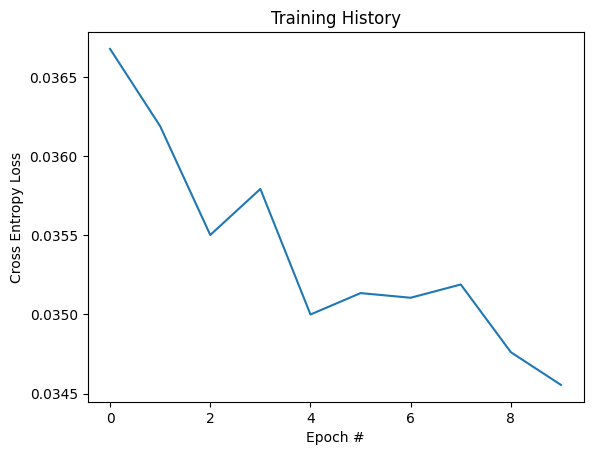

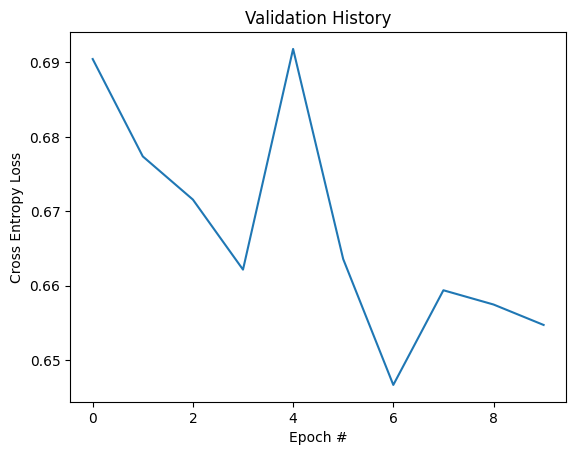

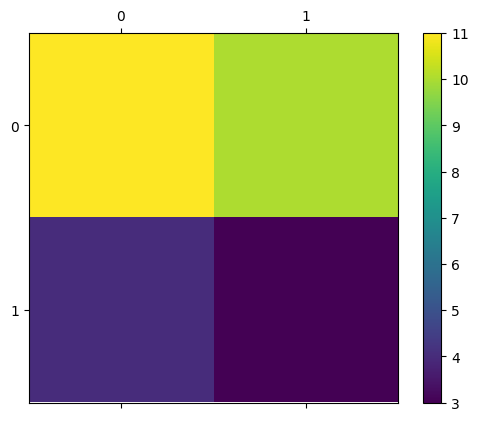

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
model = model.to(device)

train_history, val_history  = train_model(model, optimizer, ephocs=10)

actual = []
predicted = []
with torch.no_grad():
  actual, predicted = check_accuracy(test_dataloader, model, val_history, 'test')
  f1 = get_f1(actual, predicted, 2)
  print("f1 = " + str(f1));
  confusion = get_confusion(actual, predicted)
  generate_figures(train_history, val_history, confusion, [], [])

In [ ]:
def train_model(model, optimizer, ephocs):
  train_history = []
  val_history = []
  for epoch in range(N_EPHOCS):
      train_loss = 0.0
      train_acc = 0.0
      model.train()


      for index, (spectrogram, labels) in enumerate(train_dataloader):
          spectrogram = spectrogram.to(device=device, dtype=dtype)
          labels = labels.to(device=device, dtype=torch.long)
          optimizer.zero_grad()
          spectrogram = spectrogram.squeeze().to(device)
          outputs = model(spectrogram.unsqueeze(1))

          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          train_acc += (predicted == labels).sum().item()
      train_loss /= len(train_dataset)
      train_acc /= len(train_dataset)
      train_history.append(train_loss)
      print(f"Epoch {epoch+1}/{N_EPHOCS}")
      check_accuracy(val_dataloader, model, val_history, 'val')
      print(f"Training Loss: {train_loss:.4f}")
  return train_history, val_history



In [ ]:
check_accuracy(test_dataloader, model)

TypeError: ignored